# Introdução

A operadora de comunicações **Interconnect** gostaria de ser capaz de predizer a rotatividade de seus clientes. Se for descoberto que um usuário está planejando trocar de operadora, a empresa oferecerá-lhe códigos promocionais e opções de plano especiais. A equipe de marketing da **Interconnect** coletou alguns dados pessoais da sua clientela, incluindo a informação sobre seus planos e contratos. 

Em resumo, a **Interconect** precisa de um modelo que preveja quando um cliente deseja trocar de operadora, a fim de elaborar estratégias para reter esses clientes na operadora. Para construir o modelo, eu preciso entender as informações fornecidas, compreender o que os dados têm a me dizer e, assim, terei uma direção para a construção do modelo.

## 1- Abertura dos dados e importação da bibliotecas.

### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFE 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score,roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder


from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Abertura dos dados.

In [2]:
try:
    contract = pd.read_csv('/Users/HP/Documents/Curso_de_Ciencia_de_dados/Projetos/16-Projeto final/final_provider/contract.csv')
    personal = pd.read_csv('/Users/HP/Documents/Curso_de_Ciencia_de_dados/Projetos/16-Projeto final/final_provider/personal.csv')
    internet = pd.read_csv('/Users/HP/Documents/Curso_de_Ciencia_de_dados/Projetos/16-Projeto final/final_provider/internet.csv')
    phone = pd.read_csv('/Users/HP/Documents/Curso_de_Ciencia_de_dados/Projetos/16-Projeto final/final_provider/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Abertura dos dados nas varáveis contract, personal, internet e phone.

-------------------------------------------------------------------------------------------------------------------------------

## 2- Análise inicial.

In [3]:
# Função para visualização inicial.
def inf_geral(data=pd.DataFrame()):
    print(35*' ','Amostra dos Dados')
    display(data.head())
    print(120* '-')
    print(35*' ','Informações Gerais')
    display(data.info())
    print(120* '-')
    print(35*' ','Verificação de Duplicatas')
    display(data.duplicated().sum())
    print(120* '-')
    print(35*' ','Verificação de valores ausentes')
    display(data.isna().sum())
    print(120* '-')

A função abaixo recebe um DataFrame e retorna os métodos ``.head()``, ``.info()``, .``duplicated().sum()`` e ``.isna().sum()``.

In [4]:
# Informações gerais
inf_geral(contract)

                                    Amostra dos Dados


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


------------------------------------------------------------------------------------------------------------------------
                                    Informações Gerais
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

------------------------------------------------------------------------------------------------------------------------
                                    Verificação de Duplicatas


0

------------------------------------------------------------------------------------------------------------------------
                                    Verificação de valores ausentes


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

------------------------------------------------------------------------------------------------------------------------


In [5]:
try:
    contract['TotalCharges'] = contract['TotalCharges'].astype('float')
except:
    print('erro')

erro


In [6]:
index = 0
erros = pd.DataFrame()
while index <= contract['TotalCharges'].count() - 1:
    try:
        pd.to_numeric(contract.iloc[index,7])
        index += 1
    except:
        print('Index {}: Valor \"{}\"'.format(index,contract.iloc[index,7]))
        index += 1

Index 488: Valor " "
Index 753: Valor " "
Index 936: Valor " "
Index 1082: Valor " "
Index 1340: Valor " "
Index 3331: Valor " "
Index 3826: Valor " "
Index 4380: Valor " "
Index 5218: Valor " "
Index 6670: Valor " "
Index 6754: Valor " "


A tabela ``contract`` possui 7 colunas com informações sobre a contratação dos planos de cada cliente e uma coluna "ID". Nas informações gerais, foi possível identificar erros de tipo nas colunas ``BeginDate``, ``EndDate`` e ``TotalCharges``. Não há valores ausentes nem duplicados explícito, porem ao tentar converter a coluna `TotalCharges` em "float" ele indicou uma "string" com o valor `''`. Não existe documentação que indique qual informação cada coluna carrega, então terei que investigá-las.

In [7]:
# Informações gerais
inf_geral(personal)

                                    Amostra dos Dados


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


------------------------------------------------------------------------------------------------------------------------
                                    Informações Gerais
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

------------------------------------------------------------------------------------------------------------------------
                                    Verificação de Duplicatas


0

------------------------------------------------------------------------------------------------------------------------
                                    Verificação de valores ausentes


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

------------------------------------------------------------------------------------------------------------------------


A tabela contém as informações pessoais, como mencionado anteriormente. Nela, há 5 colunas que são fáceis de compreender. As colunas possuem valores binários, que poderão ser substituídos por zeros e uns .

In [8]:
# Informações gerais
inf_geral(internet)

                                    Amostra dos Dados


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


------------------------------------------------------------------------------------------------------------------------
                                    Informações Gerais
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

------------------------------------------------------------------------------------------------------------------------
                                    Verificação de Duplicatas


0

------------------------------------------------------------------------------------------------------------------------
                                    Verificação de valores ausentes


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

------------------------------------------------------------------------------------------------------------------------


A tabela ``internet`` possui 8 colunas. Seis delas contêm valores booleanos que serão substituídos por 0 e 1 e convertidos para o tipo ``int``, pois é o tipo mais adequado para modelos de machine learning. Não foi encontrado valores ausentes nem duplicados. As colunas dessa tabelas são mais fáceis de interpretar, não irei fazer uma investigação detalhada para elas. 

In [9]:
inf_geral(phone)

                                    Amostra dos Dados


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


------------------------------------------------------------------------------------------------------------------------
                                    Informações Gerais
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

------------------------------------------------------------------------------------------------------------------------
                                    Verificação de Duplicatas


0

------------------------------------------------------------------------------------------------------------------------
                                    Verificação de valores ausentes


customerID       0
MultipleLines    0
dtype: int64

------------------------------------------------------------------------------------------------------------------------


Essa tabela só possui 2 colunas: uma com o "ID" e a outra indicando se há mais de uma linha de telefonia.

**Conclusão**

No arquivo ``contract``, temos informações sobre a data em que o usuário começou a usar o plano, a data de cancelamento do plano, a forma como o serviço é cobrado, se o faturamento é em papel, a forma de pagamento, o valor da mensalidade e o custo total.

O arquivo ``personal`` contém informações pessoais, como gênero, se a pessoa é aposentada, se tem parceiro ou parceira, e quantos dependentes possui.

No arquivo ``internet``, encontramos informações sobre o tipo de fornecimento de internet (fibra óptica e DSL) e serviços extras de internet, como backup, streaming, etc.

Em ``Partnerphone``, há apenas uma coluna que indica se o usuário possui múltiplas linhas.

Os arquivos "internet" e "phone" têm menos linhas do que as outras duas colunas, e você pretende continuar o projeto considerando que essas linhas faltantes ocorrem porque os usuários não possuem tais serviços no plano. Você identificou valores ausentes em "TotalCharges" e planeja imputar novos valores quando os dados estiverem divididos em treino, validação e teste, a fim de evitar vazamento de dados. O valor objetivo está na coluna "EndDate," e você pretende criar uma nova coluna ou substituir os valores ausentes por 1 e as datas por 0. Para analisar a correlação das colunas e a distribuição, será necessário transformar todos os dados categóricos em numéricos.

-------------------------------------------------------------------------------------------------------------------------------

## 3- Modelagem dos dados e análise explóratoria.

### Preparando os dados.

Primeiro vou preencher os valores ausentes por "NaN", assim é possível convertê-los para float e continuar a análise sem alterar esses valores. Depois, alterar o tipo de "BeginDate" para "datetime".

In [10]:
contract['TotalCharges'] = contract['TotalCharges'].replace(' ',np.nan).astype('float64')

In [11]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Agora vou converter todas as colunas Categóricas em numéricas. Para isso vou utilizar uma função que vai ferificar quantos valores categóricos a coluna tem e criar um novo valor numérico.

In [12]:
def conversor(series):
    if ['Yes','No'] in series.unique(): # Condicional para verificar se o objeto series tem "Yes" ou "No" e atribuir 1 e 0. 
        return series.map({'Yes': 1, 'No': 0}) # Caso a condicional seja atendida.
    else:
        valores = series.unique() # Recebe todos os valores unicos do objeto series. 
        # Esse codigo conta quantos valores existem no objeto series e cria um valor numérico.
        numeros = np.arange(len(series.unique())) 
        # Os valores e numeros são unidos em um dicionário para ser usado para o mapeamendo dos novos valores do objeto series.
        return series.map({antigo: novo for antigo, novo in zip(valores,numeros)}) 

A função mencionada realiza a conversão de características categóricas alfabéticas em representações numéricas. No geral, quando a coluna contém valores como "Yes" e "No", indicando a presença ou ausência de um serviço, a função automaticamente associa o valor "Yes" ao número 1 e o valor "No" ao número 0. Caso esses valores específicos não estejam presentes na coluna, a função realiza uma enumeração, atribuindo números únicos a cada categoria, garantindo uma categorização adequada para análises  e treinamento do modelo. Eu preferi escrever a função para isso se no meio do projeto eu quisesse realizar alguma alteração nas representação das categorias.

In [13]:
# Transformando os dados em contract.
for i in contract.iloc[:,3:6].columns:
    contract[i] = conversor(contract[i])
display(contract.head(5))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,0,1,0,29.85,29.85
1,5575-GNVDE,2017-04-01,No,1,0,1,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,1,53.85,108.15
3,7795-CFOCW,2016-05-01,No,1,0,2,42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,0,70.70,151.65


In [14]:
# Transformando os dados em personal
for i in personal.drop(['customerID','SeniorCitizen'],axis=1).columns:
    personal[i] = conversor(personal[i])
display(personal.head(5))

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0


In [15]:
# Transformando os dados em internet.
for i in internet.drop('customerID',axis=1).columns:
    internet[i] = conversor(internet[i])
display(internet.head(5))

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,0,0,1,0,0,0,0
1,5575-GNVDE,0,1,0,1,0,0,0
2,3668-QPYBK,0,1,1,0,0,0,0
3,7795-CFOCW,0,1,0,1,1,0,0
4,9237-HQITU,1,0,0,0,0,0,0


In [16]:
# Transformando os dados em phone.
phone['MultipleLines'] = conversor(phone['MultipleLines'])
display(phone.head(5))

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


Por fim vou criar uma coluna com a *feature objetivo*, baseado na coluna "EndDate".

In [17]:
objetivo = []
for i in contract['EndDate']:
    if i == 'No' :
        objetivo.append(0)
    else:
        objetivo.append(1)

contract['objetivo'] = objetivo

Agora que as colunas foram convertidas é possível analisá-las melhor.

-------------------------------------------------------------------------------------------------------------------------------

### Análise Exploratória.

Os únicos valores que não são categóricos são "MonthlyCharges" e "TotalCharges". Vou verificar a distribuição e garantir que não há valores atípicos.

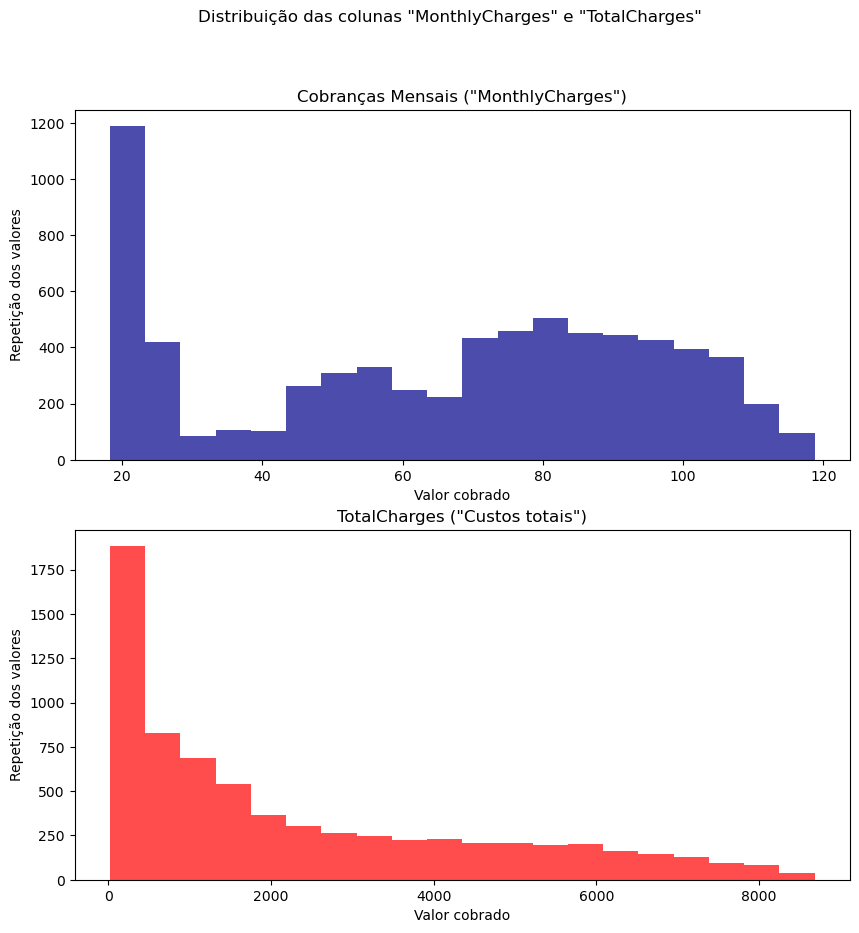

In [18]:
fig, axes = plt.subplots(2,1, figsize=(10, 10))

axes[0].hist(contract['MonthlyCharges'], bins=20,color='darkblue',alpha=0.7)
axes[0].set(title='Cobranças Mensais ("MonthlyCharges")', xlabel='Valor cobrado', ylabel='Repetição dos valores')
axes[1].hist(contract['TotalCharges'], bins=20,color='red',alpha=0.7)
axes[1].set(title='TotalCharges ("Custos totais")', xlabel='Valor cobrado', ylabel='Repetição dos valores')

fig.suptitle('Distribuição das colunas "MonthlyCharges" e "TotalCharges"')

fig.show()

Existe uma grande repetição de valores em torno de 20 para as duas colunas, mas não é nada que vá atrapalhar o treinamento dos modelos. Pela distribuição, não foi possível encontrar nenhum valor atípico. Vou dar mais uma olhada com o boxplot.

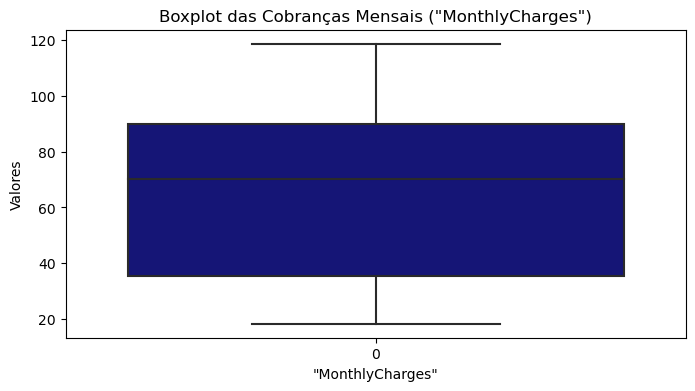

In [19]:
plt.figure(figsize=(8, 4))
sns.boxplot(contract['MonthlyCharges'],saturation=0.7,color='darkblue')
plt.title('Boxplot das Cobranças Mensais ("MonthlyCharges")')
plt.xlabel('"MonthlyCharges"')
plt.ylabel('Valores')
plt.show()

Os valores se concentram entre 37 e 90. Não existem valores ultrapassando o intervalo interquartil inferior e superior. Ou seja, não existem valores atípicos em "MonthlyCharges".

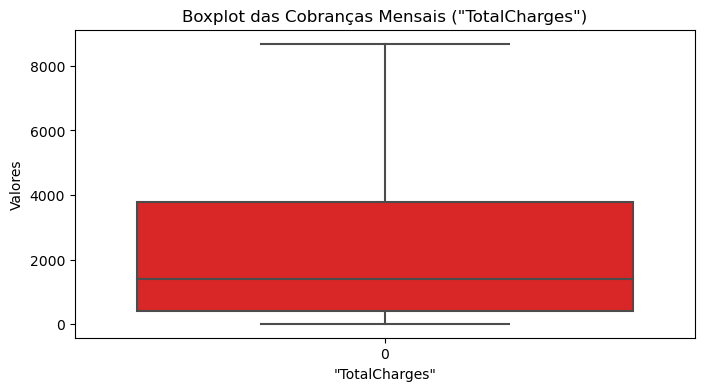

In [20]:
plt.figure(figsize=(8, 4))
sns.boxplot(contract['TotalCharges'],color='red',saturation=0.7)
plt.title('Boxplot das Cobranças Mensais ("TotalCharges")')
plt.xlabel('"TotalCharges"')
plt.ylabel('Valores')
plt.show()

Os valores se concentram entre 400 e 3790 e também não há valores ausentes no "MonhlyCharges".

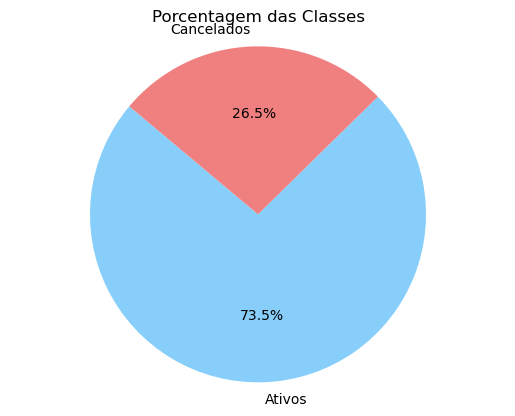

In [21]:
# Contagem de ocorrências de cada classe
contagem_classe_0 = list(contract['objetivo']).count(0)
contagem_classe_1 = list(contract['objetivo']).count(1)

# Calcule as porcentagens
total = len(contract['objetivo'])
porcentagem_classe_0 = (contagem_classe_0 / total) * 100
porcentagem_classe_1 = (contagem_classe_1 / total) * 100


# Valores das fatias
valores = [porcentagem_classe_0, porcentagem_classe_1]


# Crie o gráfico de pizza
plt.pie(valores, labels=['Ativos', 'Cancelados'], colors=['lightskyblue','lightcoral'], autopct='%1.1f%%', startangle=140)

# Adicione um título
plt.title('Porcentagem das Classes')

# Exiba o gráfico
plt.axis('equal')  # Isso garante que o gráfico seja uma forma de círculo
plt.show()

A classe objetivo está desequilibrada, praticamente 1/4 é da classe positiva. O desequilíbrio pode afetar o resultado do treinamento, fazendo com que os modelos apresentem resultados ruins. Irei realizar uma superamostragem.

### Correlação

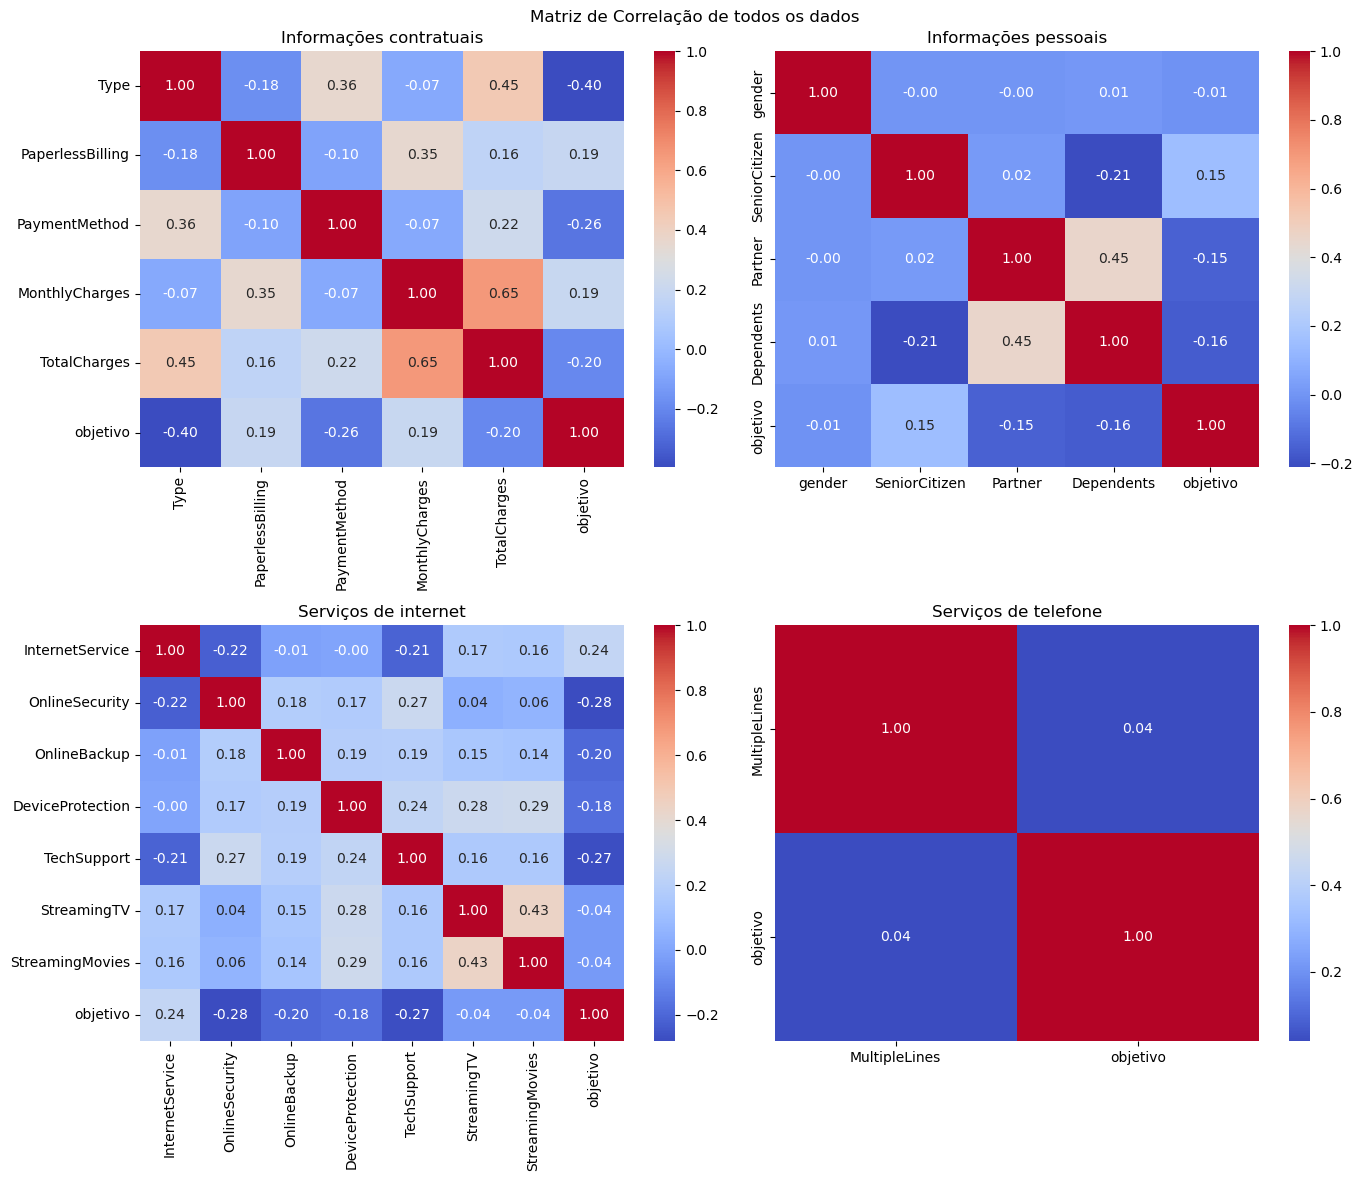

In [22]:
personal_corr = personal.merge(contract[['customerID','objetivo']],on='customerID')
internet_corr = internet.merge(contract[['customerID','objetivo']],on='customerID')
phone_corr = phone.merge(contract[['customerID','objetivo']],on='customerID')
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Adicione os heatmaps aos subplots
sns.heatmap(data=contract.corr(), ax=axs[0, 0], annot=True, cmap='coolwarm', fmt=".2f")
axs[0, 0].set_title('Informações contratuais')

sns.heatmap(data=personal_corr.corr(), ax=axs[0, 1], annot=True, cmap='coolwarm', fmt=".2f")
axs[0, 1].set_title('Informações pessoais')

sns.heatmap(data=internet_corr.corr(), ax=axs[1, 0], annot=True, cmap='coolwarm', fmt=".2f")
axs[1, 0].set_title('Serviços de internet')

sns.heatmap(data=phone_corr.corr(), ax=axs[1, 1], annot=True, cmap='coolwarm', fmt=".2f")
axs[1, 1].set_title('Serviços de telefone')

fig.suptitle('Matriz de Correlação de todos os dados')
# Ajuste o layout da figura para evitar sobreposições
plt.tight_layout()

# Exiba a figura
plt.show()

Existem muitas características, por isso, observar a correlação vai me ajudar a filtrar as mais relevantes. As características de gênero, *streamingTV* e *streamingMovies* têm uma correlação baixa com o objetivo, portanto, não serão tão relevantes no treinamento do modelo. As colunas contendo os serviços de internet podem ser combinadas, assim, ao invés de ter uma coluna para cada serviço, vou ter uma coluna contendo quantos serviços o usuário tem.

In [23]:
internet_corr['servicos'] = internet_corr.drop(['customerID','InternetService','objetivo'],axis=1).apply(np.sum,axis=1)
internet['servicos'] = internet_corr['servicos']

<Axes: >

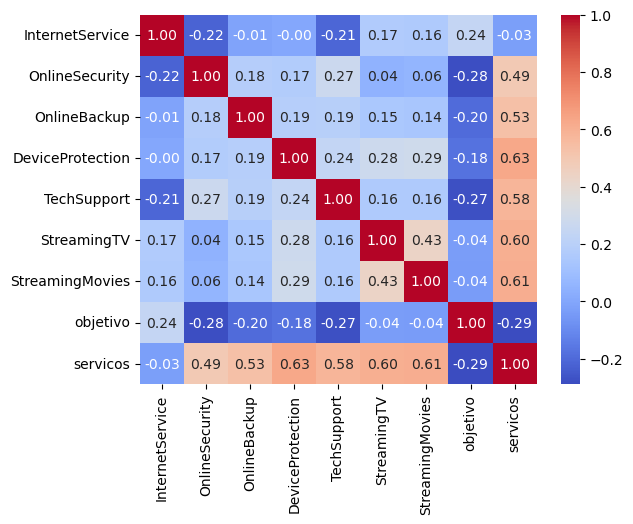

In [24]:
sns.heatmap(data=internet_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")

**Conclusão**

A nova característica trouxe uma relação negativa maior do que as demais características do conjunto de internet. A característica gênero e os serviços de internet individuais não serão usados. A característica "BeginDate" será mantida para ser usada apenas no modelo catboost, que aceita dados do tipo ``datetime``. Nos demais modelos, ela será excluída.

## Treinamento e Teste de modelos.

In [25]:
#Preparando os dados para o treinamento 
x = contract.merge(internet,on='customerID',how='left')
x = x.merge(personal,on='customerID',how='left')
x = x.merge(phone,on='customerID',how='left')
x = x.drop(['OnlineSecurity','OnlineBackup','DeviceProtection',
                   'TechSupport','StreamingTV','StreamingMovies','gender'],axis=1)

Existe uma diferença na quantidade de dados entre os conjuntos 'phone' e 'internet'. Acredito que essa diferença ocorra devido ao fato de que nem todos os usuários possuem esses serviços. Como os conjuntos são desiguais, a união deles resultou em dados com valores ausentes. Portanto, irei substituir esses valores por 0, pois acredito que esses usuários não possuem esses serviços.

In [26]:
x['InternetService'] = x['InternetService'].fillna(0)
x['servicos'] = x['servicos'].fillna(0)
x['MultipleLines'] = x['MultipleLines'].fillna(0)

In [27]:
y = x[['objetivo']]
x = x.drop(['customerID','EndDate','objetivo'],axis=1)

Agora irei separar o conjunto de dados em base de treino e teste. Para validação, vou utilizar o "cross_validation" embutido no ``RandomizedSearchCV``. Os valores ausentes da coluna "TotalCharges" serão imputados depois da separação dos dados.

In [28]:
# Imputador configurado com a média.
imp_median = SimpleImputer(strategy='mean')

In [29]:
#Conjunto de treino 60% e test 40%.
x_train, x_test, y_train ,y_test = train_test_split(x, y, test_size=0.4, random_state=12345)

x_train['TotalCharges'] = imp_median.fit_transform(x_train['TotalCharges'].values.reshape(-1,1)).flatten()
x_test['TotalCharges'] = imp_median.fit_transform(x_test['TotalCharges'].values.reshape(-1,1)).flatten()

display(x_train['TotalCharges'].count())
display(x_test['TotalCharges'].count())

4225

2818

### Treinamento.

***Gradient Boosting Classifier do sklearn.***

In [30]:
%%time
# Pepiline com os hiperparâmetros.
SGBC_param = { 'learning_rate': [0.1,0.01,0.02,0.05],
             'n_estimators':[2000,5000,6000,7000,8000]
           } 

# Modelo.
SGBC = GradientBoostingClassifier()

# Teste de hiperparâmetros.
SGBC_grid = RandomizedSearchCV(SGBC, SGBC_param, n_iter=32, 
                             scoring="roc_auc",n_jobs=-1,random_state=123)
# Resultados.
SGBC_model = SGBC_grid.fit(x_train.drop('BeginDate',axis=1), y_train)
print(SGBC_model.best_estimator_)
print(SGBC_model.best_score_)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=2000)
0.8381852833169846
CPU times: total: 15.9 s
Wall time: 27min 12s


***Random Forest Classifier.***

In [31]:
%%time
RFC_param = {'n_estimators':[40,50,60,70,80,90,100],
             'max_depth':[1,2,3,4,5,6,7,8,10]}

RFC = RandomForestClassifier(random_state=12345,n_estimators=100)

RFC_grid = RandomizedSearchCV(RFC, RFC_param, n_iter=32, 
                             scoring="roc_auc",n_jobs=-1,random_state=123) 
#Resultados
RFC_model = RFC_grid.fit(x_train.drop('BeginDate',axis=1), y_train)
print(RFC_model.best_estimator_)
print(RFC_model.best_score_)

RandomForestClassifier(max_depth=7, random_state=12345)
0.8420845787847145
CPU times: total: 1.67 s
Wall time: 27.3 s


***CatBoost Classifier.***

In [32]:
%%time
# Pepiline com os hiperparâmetros.
CB_param = { 'learning_rate': [0.1,0.01,0.02,0.05],
             'n_estimators':[2000,5000,6000,7000,8000]
           } 

# Modelo.
CB = CatBoostClassifier(verbose=0,random_state=123)

# Teste de hiperparâmetros.
CB_grid = RandomizedSearchCV(CB, CB_param, n_iter=32, 
                             scoring="roc_auc",n_jobs=-1,random_state=123)
# Resultados.
CB_model = CB_grid.fit(x_train, y_train)
print(CB_model.best_estimator_)
print(CB_model.best_score_)

0.9264861359153667
CPU times: total: 1min 38s
Wall time: 20min 14s


***LightGBM Classifier.***

In [33]:
%%time
# Pepiline com os hiperparâmetros.
LGB_param = { 'learning_rate': [0.1,0.01,0.02,0.05],
             'n_estimators':[1000,2000,3000,4000,5000]
            }

# Modelo.
LGB = LGBMClassifier(random_state=123)
# Teste dehiperparâmetros.
LGB_grid = RandomizedSearchCV(LGB, LGB_param, n_iter=32, 
                    scoring="roc_auc", n_jobs=-1,random_state=123)
# Resultados.
LGB_model = LGB_grid.fit(x_train.set_index('BeginDate',drop=True), y_train)
print(LGB_model.best_estimator_)
print(LGB_model.best_score_)

[LightGBM] [Info] Number of positive: 1101, number of negative: 3124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260592 -> initscore=-1.042895
[LightGBM] [Info] Start training from score -1.042895
LGBMClassifier(learning_rate=0.01, n_estimators=1000, random_state=123)
0.833363938697803
CPU times: total: 3.42 s
Wall time: 5min 23s


***XGBoost Classifier.***

In [34]:
%%time
# Pepiline com os hiperparâmetros.
XGB_param = { 'learning_rate': [0.01,0.1,0.02,0.05],
             'n_estimators':[1000,2000,3000,4000,5000]
            } 

# Modelo.
XGB = XGBClassifier(random_state=123)
# Teste dehiperparâmetros.
XGB_grid = RandomizedSearchCV(XGB, XGB_param, n_iter=32, 
                    scoring="roc_auc", n_jobs=-1,random_state=123)
# Resultados.
XGB_model = XGB_grid.fit(x_train.set_index('BeginDate',drop=True), y_train)
print(XGB_model.best_estimator_)
print(XGB_model.best_score_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)
0.8328045175668976
CPU times: total: 3.86 s
Wall time: 3min 10s


**Coclusão do Treinamento.** 

Para obter o melhor desempenho de cada modelo, foi utilizada a tunagem de hiperparâmetros com diferentes configurações para ``n_estimator``, ``learning_rate`` e ``max_depth`` para a RandomForest. O modelo com melhor desempenho foi o CatBoost com 0,92, talvez devido ao fato de ele aceitar características do tipo ``datetime``.

### Teste .

In [35]:
#Teste do modelo.
pred = CB_model.predict(x_test)
print('AUC_ROC:',roc_auc_score(pred,y_test))
print('Precisão:',precision_score(pred,y_test))
print('Acuracia:',accuracy_score(pred,y_test))

AUC_ROC: 0.8993767590719397
Precisão: 0.703125
Acuracia: 0.8981547196593329


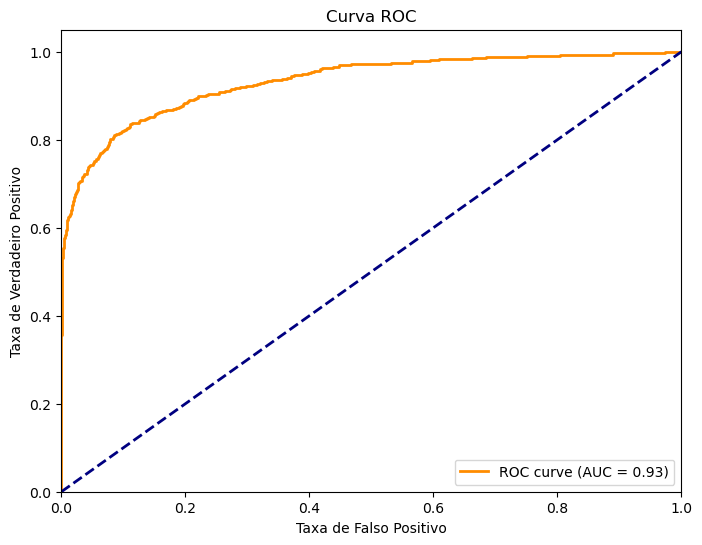

In [36]:
# obtendo as probabilidaed prevista pelo modelo.
pred_probs = CB_model.predict_proba(x_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)  # pred_probs é a verdadeira classe
roc_auc = auc(fpr, tpr)

# Plotando o gráfico.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

**Coclusão do teste.**



O treinamento e teste foram feitos usando a métrica AUC-ROC. Essa métrica ajuda a medir quão bom é um modelo de classificação em separar coisas em duas categorias, como "sim" e "não". Quanto mais próxima a métrica estiver de 1, melhor é o modelo. Se estiver perto de 0,5, o modelo não é muito bom em fazer essa separação e está praticamente adivinhando. O modelo escolhido conseguiu atingir 0.899, apresentando um bom resultado.

## Conclusão.

Para ajudar a empresa **Interconnect** a identificar usuários que pretendem deixar de usar seus serviços, este projeto teve como objetivo criar um modelo de machine learning que identificasse o cancelamento dos planos oferecidos pela **Interconnect**.

A equipe de marketing me forneceu 4 arquivos contendo dados dos seus usuários. Neles, havia informações contratuais, pessoais, serviços de internet e telefone oferecidos pela empresa. Nas informações contratuais, havia as datas da contratação e do cancelamento, além de outras informações como o tipo de cobrança, valor cobrado por mês, total cobrado e outras informações não tão relevantes. Os dados de contrato e serviços de internet são os que têm mais valor. As informações pessoais e do serviço telefônico também têm seu valor, mas não tanto em comparação aos outros dois.

Na análise inicial, foi possível ver uma diferença na quantidade de linhas entre os DataFrames de serviços de internet e telefone. Acredito que essa diferença seja devido ao fato do usuário não possuir tal serviço e, por isso, não existe registro deles nesses dados. Portanto, substituí esses valores por 0, que categoricamente é o valor para quem não possui o serviço. Identifiquei valores ausentes na coluna "TotalCharges". Os valores ausentes foram imputados com a média de seu conjunto de dados. Os dados foram divididos em dois conjuntos antes do treinamento do modelo.

Já na análise exploratória, foi observada a distribuição das características numéricas "MonthlyCharges" e "TotalCharges", bem como a correlação dos dados com a característica objetivo. Reduzi os serviços de internet somando-os e criando uma nova característica.

Com os dados prontos, selecionei 4 modelos de "gradient boosting" e 1 modelo ensemble. Para o treinamento, utilizei uma função de tunagem de hiperparâmetros que testa diferentes configurações e retorna a que tem o melhor desempenho e já treina o modelo. O modelo de Floresta Aleatória teve um desempenho superior em relação à maioria dos modelos de gradiente. No entanto, o modelo CatBoost foi muito superior a todos os modelos. Acredito que esse resultado tenha sido pelo fato dele aceitar objetos "datetime", ao contrário dos outros modelos.